In [1]:
import collections
import os
import random
from os.path import join as opj
import numpy as np
import pandas as pd
from PIL import Image
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud, get_single_color_func
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

cmap = plt.cm.Spectral
%matplotlib inline

In [2]:
def topn(d, n):
    c = collections.Counter(d)
    return {k:v for k, v in c.most_common(n)}


def get_normalized_model(m, tm):
    m = np.dot(m, tm.components_)
    m-=m.mean(0)
    m-=np.min(m)
    m/=np.max(m)
    return m


class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)
    
    
def plot_wordle(ax, textdict, maskpath=None):
    circle = np.array(Image.open(maskpath))
    wc = WordCloud(max_font_size=50, collocations=False, max_words=200, background_color="white", mask=circle, width=2000, height=1000, colormap=plt.cm.Reds)
    wc.generate_from_frequencies(textdict)
    ax.imshow(wc.recolor(color_func=grouped_color_func, random_state=3),
           interpolation="bilinear")
    ax.axis("off")
    
    
def plot_image(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    im.image.axes=ax
    artists = []
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
    return artists


def add_arrows(axes, x, y, **kwargs):
    # spacing of arrows
    aspace = .05 # good value for scale of 1
    aspace *= scale

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1]
        dy = y[i]-y[i-1]
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = 0 # current point on walk along data
    rcount = 1 
    while arrowPos < r.sum():
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]: 
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    # could be done in above block if you want
    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit
        axes.arrow(ax,ay,
                   np.sin(theta)*aspace/10,np.cos(theta)*aspace/10, 
                   head_width=aspace/3, **kwargs)

In [3]:
def _z2r(z):
    """
    Function that calculates the inverse Fisher z-transformation

    Parameters
    ----------
    z : int or ndarray
        Fishers z transformed correlation value

    Returns
    ----------
    result : int or ndarray
        Correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    

def _r2z(r):
    """
    Function that calculates the Fisher z-transformation

    Parameters
    ----------
    r : int or ndarray
        Correlation value

    Returns
    ----------
    result : int or ndarray
        Fishers z transformed correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    
    
def corr_mean(rs, axis=0):
    """
    Function that calculates the mean of correlation coefficients,
    performing Fisher z-transformation and inverse z-transormation
    
    Parameters
    ----------
    rs: : list or ndarray
        Correlation values
    
    Returns
    ----------
    result : float
        mean of correlation values

    """
    return _z2r(np.nanmean([_r2z(r) for r in rs], axis=axis))


def bootstrap_ci_corrs(M, ci=95, n_boots=1000, color='#1f77b4', alpha=0.2, label=None):
    evs = np.arange(M.shape[0])
    y = corr_mean(M, axis=1)
    ci_low = (100 - ci) / 2
    ci_high = 100 - ci_low
    L, U = np.empty(evs.shape), np.empty(evs.shape)
    # constructs a single resample
    boot_mean = lambda x: np.random.choice(x, size=len(x), replace=True).mean()
    
    for ev in evs:
        zev_dists = _r2z(M[ev])
        boot_iter = (boot_mean(zev_dists) for n in range(n_boots))
        zboots = np.fromiter(boot_iter, dtype=float)
        # use percentile bootstrap (seaborn default method)
        L[ev], U[ev] = _z2r(np.percentile(zboots, ci_low)), _z2r(np.percentile(zboots, ci_high))
    
    # error ribbons
    h1 = plt.fill_between(evs, L, U, color=color, alpha=alpha)
    # opaque line
    h2 = plt.plot(evs, y, color=color, label=label)
    return h1, h2

### Set path and params

In [4]:
datadir = '/mnt/data/processed/'
figdir = '/mnt/paper/figs/'
tmp_dir = opj(figdir, 'tmp')
# os.mkdir(tmp_dir)

default_color = 'grey'
n = 50

### Load data

In [5]:
video_events = np.load(opj(datadir, 'video_events.npy'))
recall_events = np.load(opj(datadir, 'recall_events.npy'), allow_pickle=True)
avg_recall_events = np.load(opj(datadir, 'avg_recall_events.npy'), allow_pickle=True)
matches = np.load(opj(datadir, 'labels.npy'), allow_pickle=True)
text_corpus = np.load(opj(datadir, 'video_text.npy'), allow_pickle=True)
embeddings = np.load(opj(datadir, 'embeddings.npy'), allow_pickle=True)
video_embedding = embeddings[0]
recall_embeddings = embeddings[2]

### Compute distances

In [6]:
dists = []
for v in video_events:
    dist = []
    for sub in recall_events:
        dist.append(np.max(1 - cdist(np.atleast_2d(v), sub, 'correlation')))
    dists.append(dist)
dists = np.array(dists)     

### Plot the result

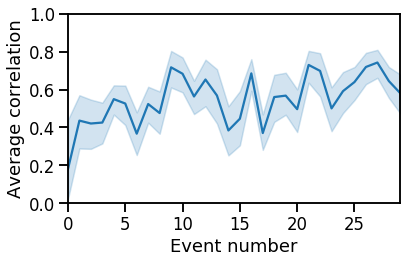

In [7]:
sns.set_context('talk')
bootstrap_ci_corrs(dists)
plt.xlim(0,29)
plt.ylim(0,1)
plt.xlabel('Event number')
plt.ylabel('Average correlation')
plt.tight_layout()
# plt.savefig(opj(tmp_dir, 'precision.pdf'))
plt.show()

## Fit topic model to video annotation sliding windows

In [ ]:
cv = CountVectorizer(stop_words='english')
fit_cv = cv.fit_transform(text_corpus)
tm = LatentDirichletAllocation(n_components=100, learning_method='batch', random_state=0).fit(fit_cv)

In [ ]:
np.save(opj(datadir, 'count_vectorizer_model'), cv)
np.save(opj(datadir, 'topic_model'), tm)

In [ ]:
norm_video_events = get_normalized_model(video_events, tm)
norm_avg_recall_events = get_normalized_model(avg_recall_events, tm)

## Wordle figures

In [ ]:
for seg in range(video_events.shape[0]):
    weights = norm_video_events[seg, :]
    textdict_video = topn({word: weight for word, weight in zip(cv.get_feature_names(), weights)}, n)
    weights = norm_avg_recall_events[seg,:]
    textdict_recall = topn({word: weight for word, weight in zip(cv.get_feature_names(), weights)}, n)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    color_to_words = {'black': list(set(textdict_video))}
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    plot_wordle(ax1, textdict_video, maskpath=opj(datadir, "half-moon-left.jpg"))
    color_to_words = {'black': list(set(textdict_recall))}
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    plot_wordle(ax2, textdict_recall, maskpath=opj(datadir, "half-moon.jpg"))
    plt.subplots_adjust(wspace=-.5, hspace=-.5)
    fig.patch.set_visible(False)
#     plt.savefig(opj(tmp_dir, f'wordle_event{seg}.png'), dpi=300)
    plt.close()

### Weighted average of the event vectors by memorability

In [ ]:
mdist = corr_mean(dists, axis=1)
rvec = np.zeros_like(video_events[0])
fvec = np.zeros_like(video_events[0])
rsum = 0
fsum = 0
for v, w in zip(video_events, mdist):
    rvec += v * w
    rsum += w
    fvec += v * (1 - w)
    fsum += (1 - w)
r = rvec / rsum
r = r - video_events.mean(0)
f = fvec / fsum
f = f - video_events.mean(0)

## Most memorable words

In [ ]:
rweights = np.dot(r, tm.components_)
rdict = topn({word:weight for word, weight in zip(cv.get_feature_names(), rweights)}, 200)
fig, ax1 = plt.subplots(1, 1)
color_to_words = {'black': list(set(rdict))}
grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
plot_wordle(ax1, rdict, maskpath=opj(datadir, "oval2.jpg"))
# plt.savefig(opj(tmp_dir, 'most_memorable.png'), dpi=300)

## Least memorable words

In [ ]:
fweights = np.dot(f, tm.components_)
fdict = topn({word:weight for word, weight in zip(cv.get_feature_names(), fweights)}, 200)
fig, ax1 = plt.subplots(1, 1)
color_to_words = {'black': list(set(fdict))}
grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
plot_wordle(ax1, fdict, maskpath=opj(datadir, "oval2.jpg"))
# plt.savefig(opj(tmp_dir, 'least_memorable.png'), dpi=300)

## Trajectory distribution figure

In [ ]:
c = cmap(np.linspace(0, 1, 10))
sub_color = cmap(np.linspace(0, 1, 17))
subj_points = np.vstack(recall_embeddings)
fig = plt.figure()
ax = fig.add_subplot(111)
scale = 30
for i, (sub, sub_match) in enumerate(zip(recall_embeddings, matches)):
    for j, (p, m) in enumerate(zip(sub, sub_match)):
        ax.plot(p[0], p[1], 'o', c=cmap(m/video_embedding.shape[0]), alpha=.75, zorder=2, markersize=7)
        ax.plot(p[0], p[1], 'o', c='k', alpha=.5, zorder=1, markersize=8)
hinges = video_embedding
for i in range(len(hinges)-1):
    ax.plot([hinges[i, 0], hinges[i+1, 0]], [hinges[i, 1], hinges[i+1, 1]], c='k', linewidth=2, alpha=1)
for i in range(len(hinges)):
    ax.plot(hinges[i,0], hinges[i,1], 'o', c=cmap(i/hinges.shape[0]), zorder=4, markersize=mdist[i]*scale/3+5, alpha=.9)
    ax.plot(hinges[i,0], hinges[i,1], 'ko', zorder=3, markersize=mdist[i]*scale/3+7, alpha=.9)
add_arrows(ax, hinges[:, 0], hinges[:, 1], zorder=3, alpha=1, color='k', fill=True)
ax.axis('off')
# plt.savefig(opj(tmp_dir, 'trajectory_distribution.pdf'))
plt.show()